In [1]:
%matplotlib inline

import os 
import pandas as pd
import numpy as np 
import sklearn
from sklearn.decomposition import PCA as sklearnPCA
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import re 
from datetime import datetime
from datetime import timedelta
import calendar
# from bokeh.charts import HeatMap, bins, output_file, show
# from bokeh.layouts import column, gridplot
# from bokeh.palettes import RdYlGn6, RdYlGn9

## Model Exploration 

This code explore the models obtained from the MongoDB database with models of the DSSG Cincinnati project.
It provides basic statistics about models and provides a list with the top n models based on different criteria. 

### Data preprocessing

In this section we built functions that process the models database to make it easier to analyze 

In [4]:
data = pd.read_csv("output_csv.csv")

In [5]:
data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'model_id', 'validation_date',
       'radius_features', 'time_features', 'date', 'prediction', 'violations',
       'inspections', 'houses', 'inspection_density', 'violation_density'],
      dtype='object')

In [4]:
#Change names of relevant variables for analysis
data.rename(columns = {"||name":"regressor"}, inplace = True)
data.rename(columns = {"||_id":"model_id"}, inplace = True)
data.rename(columns = {"||config||validation_window":"validation_window"}, inplace = True)
data.rename(columns = {"||config||start_date":"start_date"}, inplace = True)
data.rename(columns = {"||prec_at_1":"prec_at_1"}, inplace = True)
data.rename(columns = {"||prec_at_5":"prec_at_5"}, inplace = True)
data.rename(columns = {"||prec_at_10":"prec_at_10"}, inplace = True)
data.rename(columns = {"||prec_at_20":"prec_at_20"}, inplace = True)


In [6]:
#Transform features into columns and get set of features in model 
features = data.ix[:,'||config||features'].unique()
feature_set = set()
for feature_list in features:
    clean_list = feature_list[1:-1].split(",")
    for clean_feature in clean_list:
        feature_set.add(clean_feature)

for feature in feature_set:
    data[feature] = 0
    data.loc[data['||config||features'].str.contains(feature),feature] = 1

In [7]:
data.ix[10016,"||config||features"]

"[u'fire_200m_3months.%', u'crime_200m_3months.%', u'three11_200m_3months.%', u'sales_200m_3months.%', u'permits_200m_3months.%', u'density_200m_3months.%']"

In [8]:
#Get list of parameters 
list_parameters = []
for var in data.columns:
    match = re.match("\|\|parameters.+", var)
    if match != None:
        list_parameters.append(match.group(0))
        print(match.group(0))

||parameters||max_features
||parameters||max_depth
||parameters||n_estimators
||parameters||criterion
||parameters||max_leaf_nodes
||parameters||verbose
||parameters||n_jobs
||parameters||oob_score
||parameters||min_samples_leaf
||parameters||warm_start
||parameters||min_samples_split
||parameters||bootstrap
||parameters||class_weight
||parameters||random_state
||parameters||min_weight_fraction_leaf
||parameters||penalty
||parameters||solver
||parameters||intercept_scaling
||parameters||dual
||parameters||max_iter
||parameters||fit_intercept
||parameters||tol
||parameters||C
||parameters||multi_class


In [9]:
#Parse parameter names 
parsed_list = []
for param in list_parameters: 
    parsed_param = param.replace("||parameters||","")
    data.rename(columns = {param:parsed_param}, inplace = True)
    parsed_list.append(parsed_param)
    
    

In [10]:
#Get distance and time delta of features

def get_radius(row, regular_expression):
    match = re.search(regular_expression,row)
    if match != None:
        return match.group(0)
    else:
        return "Parcel_Only" 
    
data["radius_features"] = data['||config||features'].apply(get_radius, args = ("[0-9]+m",) )
data["time_features"] = data['||config||features'].apply(get_radius, args = ("[0-9]+months",) )

In [11]:
# Get start date for validation

def add_months(sourcedate,months):
        sourcedate = datetime.strptime(sourcedate, '%d%b%Y')
        month = sourcedate.month - 1 + months
        year = int(sourcedate.year + month / 12 )
        month = month % 12 + 1
        day = calendar.monthrange(year,month)[1]
        
        dummy_date = datetime(month = month, year = 2010, day = 7)
        month = dummy_date.strftime("%b")
        return str(day) + str(month) + str(year)
    
data["validation_date"] = data['||config||fake_today'].apply(add_months, args = (6,))
data.ix[data["validation_date"] == "30Jun2016", "validation_date"] = "31Aug2016"

In [12]:
data["validation_date"].unique()

array(['31Dec2015', '30Jun2015', '31Dec2014', '31Aug2016', '30Jun2014'], dtype=object)

In [13]:
# Create CSV to use as input to get data from models 
data[["model_id","validation_date","radius_features","time_features"]].to_csv("data_for_postgres.csv")

In [14]:
#Create key identifier for model based on regressor, features radius and time
data["key_1"] = data.regressor + data.radius_features + data.time_features

### Analyze models

In [50]:
# Check the number of models and results by type of regressor
data.groupby("regressor").agg({"regressor":['count'],"prec_at_1":['max'],
                               "prec_at_5":['max'],"prec_at_10":['max'],
                               "prec_at_20":['max']}).reset_index()

,regressor,prec_at_1,regressor,prec_at_20,prec_at_10,prec_at_5
,,max,count,max,max,max
0,ExtraTreesClassifier,1.000000,68228,0.785360,0.841191,0.880597
1,LogisticRegression,0.971429,4342,0.786600,0.818859,0.865672
2,RandomForestClassifier,1.000000,69812,0.795285,0.836228,0.922619


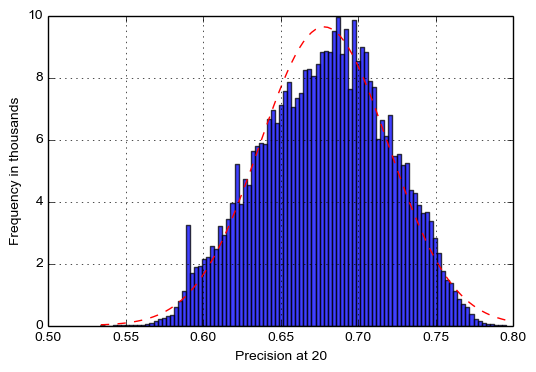

In [45]:
# Graph the histograms of precision 

## CHOOSE PRECISION AT N (as a string)
PRECISION_N = "20" 

precision = "prec_at_" + PRECISION_N

mu = data[precision].mean()
sigma = data[precision].std()

# the histogram of the data
n, bins, patches = plt.hist( data[precision], 100, normed = True, facecolor='blue', alpha=0.75)

# add a 'best fit' line
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=1)

plt.xlabel('Precision at '+ PRECISION_N)
plt.ylabel("Frequency in thousands")
plt.grid(True)

plt.show()

In [17]:
# Check which parameters are being used by type of regressor 

#CHOOSE A STATISTIC (MIN, MAX, MEAN)
STAT = "mean"

for parameter in parsed_list:
    model_param = data.groupby(["regressor",parameter]).agg({"regressor":['count'],"prec_at_1":[STAT],
                               "prec_at_5":[STAT],"prec_at_10":[STAT]})
    print(model_param)

                                    prec_at_1 regressor prec_at_10 prec_at_5
                                         mean     count       mean      mean
regressor              max_features                                         
ExtraTreesClassifier   log2          0.701364     34047   0.686778  0.694528
                       sqrt          0.715069     34181   0.690638  0.700772
RandomForestClassifier log2          0.727843     34891   0.695173  0.707905
                       sqrt          0.742554     34921   0.701193  0.716753
                                 prec_at_1 regressor prec_at_10 prec_at_5
                                      mean     count       mean      mean
regressor              max_depth                                         
ExtraTreesClassifier   1.0        0.683221      3186   0.657298  0.666861
                       5.0        0.686883      3190   0.671885  0.680231
                       10.0       0.733805     19559   0.706129  0.718497
                 

/usr/lib/python3/dist-packages/matplotlib/axes.py:4749: UserWarning: No labeled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labeled objects found. "


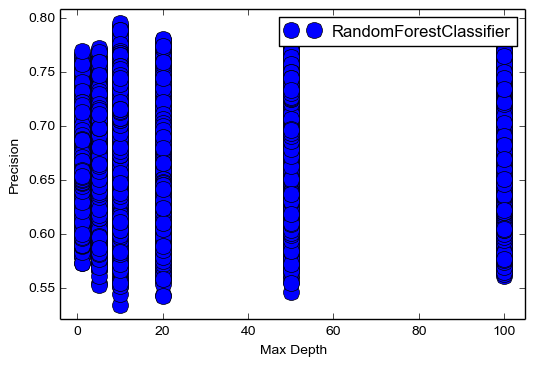

In [60]:
# Plot prec by type of models

#Choose a precision:
PRECISION = "prec_at_20"

#Choose a parameter

#  'max_features': ET, RF
#  'max_depth': ET, RF
#  'n_estimators': ET, RF
#  'criterion': ET, RF
#  'max_leaf_nodes': ET, RF
#  'verbose': ET, RF, LR
#  'n_jobs': ET, RF, LR
#  'oob_score': ET, RF
#  'min_samples_leaf': ET, RF
#  'warm_start': ET, RF, LR
#  'min_samples_split': ET, RF
#  'bootstrap': ET, RF
#  'min_weight_fraction_leaf': ET, RF
#  'penalty': LR
#  'solver':  LR
#  'intercept_scaling':  LR
#  'dual':  LR
#  'max_iter':  LR
#  'fit_intercept':  LR
#  'tol' : LR
#  'C':  LR
#  'multi_class':  LR

PARAMETER =  'max_depth'
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
groups = data.groupby("regressor")
for name, group in groups:
    if name == "RandomForestClassifier":
        ax.plot(group[PARAMETER], group[PRECISION], marker='o', linestyle='', ms=12, label=name)

    ax.legend()

plt.xlabel('Max Depth')
plt.ylabel('Precision')
    
plt.show()

### General Statistics by group of model

In [19]:
# Create a unique key to group by model, features and parameters
list_keys = parsed_list + list(feature_set) + ["regressor"]

def gen_unique_key(row, list_keys):
    unique_key = ""
    for key in list_keys:
        unique_key += str(row[key]) + "-"
    
    return unique_key
        
data["unique_key"] = data.apply(gen_unique_key, args = (list_keys,), axis = 1 )


In [20]:
len(data["unique_key"].unique())

20042

In [21]:
# Group by unique key

grouped_unique_key = data.groupby("unique_key").agg({
                               "prec_at_1":["count",'mean',"max","min","std"],
                               "prec_at_5":["count",'mean',"max","min","std"],
                               "prec_at_10":["count",'mean',"max","min","std"],
                               "prec_at_20":["count",'mean',"max","min","std"]}).reset_index()

grouped_unique_key.columns = ["key", "10_count", "10_mean", "10_max", "10_min", "10_std", 
                              "20_count", "20_mean", "20_max", "20_min", "20_std",
                              "1_count", "1_mean", "1_max", "1_min", "1_std",
                              "5_count", "5_mean", "5_max", "5_min", "5_std"]

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


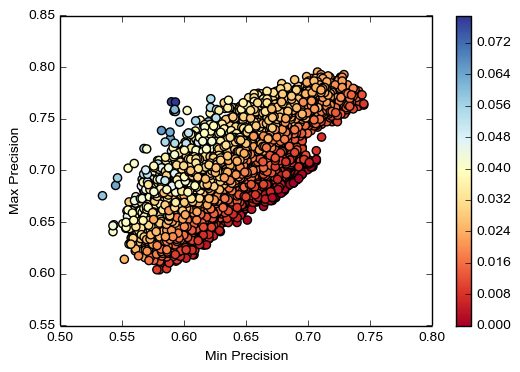

In [22]:
# Graph main results per level of precision 

##Choose precision level

PRECISION = "20"

cm = plt.cm.get_cmap('RdYlBu')

sc = plt.scatter(grouped_unique_key[PRECISION + "_min"], grouped_unique_key[PRECISION + "_max"],
                  c = grouped_unique_key[PRECISION + "_std"], s = 35, cmap = cm)

plt.xlabel('Min Precision')
plt.ylabel('Max Precision')
plt.colorbar(sc)
plt.show()

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


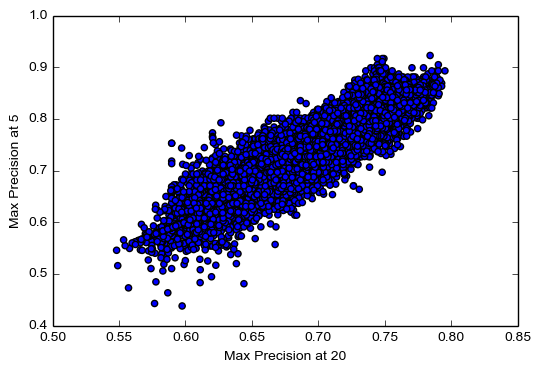

In [61]:
# Model stability

# Plot prec by type of models
##Choose precision level

PRECISION_1 = "20"
PRECISION_2 = "5" 



sc = plt.scatter(grouped_unique_key[PRECISION_1 + "_max"], grouped_unique_key[PRECISION_2 + "_max"])

plt.xlabel('Max Precision at ' + PRECISION_1)
plt.ylabel('Max Precision at ' + PRECISION_2)
plt.show()

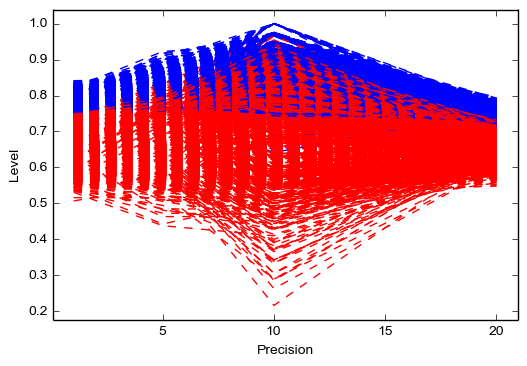

In [24]:
# Model stabilities
temporal_chart = grouped_unique_key.drop(["key", "10_count", "10_mean", "10_min", "10_std", 
                              "20_count", "20_mean", "20_min", "20_std",
                              "1_count", "1_mean", "1_min", "1_std",
                              "5_count", "5_mean", "5_min", "5_std"], axis=1)
temporal_chart = temporal_chart[["1_max","5_max","10_max","20_max"]]
temporal_chart = temporal_chart.transpose()


fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

for i in range(20000):
    if list(temporal_chart.ix[:,i])[0] >.75:
        ax.plot([1,5,10,20], list(temporal_chart.ix[:,i]), 'b--')
    else:
        ax.plot([1,5,10,20], list(temporal_chart.ix[:,i]), 'r--')
        

plt.xlabel('Precision')
plt.ylabel('Level')
plt.show()

In [25]:
grouped_data = data.groupby(["regressor", "radius_features",
                             "time_features","validation_date"]).agg({
                               "prec_at_1":['mean'],
                               "prec_at_5":['mean'],"prec_at_10":['mean'],
                               "prec_at_20":['mean']}).reset_index()

grouped_data["key_1"] = grouped_data.regressor + grouped_data.radius_features + grouped_data.time_features


In [26]:
grouped_data.head()

,regressor,radius_features,time_features,validation_date,prec_at_1,prec_at_20,prec_at_10,prec_at_5,key_1
,,,,,mean,mean,mean,mean,
0,ExtraTreesClassifier,1000m,12months,30Jun2014,0.656469,0.680669,0.692664,0.694449,ExtraTreesClassifier1000m12months
1,ExtraTreesClassifier,1000m,12months,30Jun2015,0.789035,0.701600,0.733377,0.761217,ExtraTreesClassifier1000m12months
2,ExtraTreesClassifier,1000m,12months,31Aug2016,0.672545,0.681659,0.682083,0.674271,ExtraTreesClassifier1000m12months
3,ExtraTreesClassifier,1000m,12months,31Dec2014,0.595098,0.636114,0.628215,0.622345,ExtraTreesClassifier1000m12months
4,ExtraTreesClassifier,1000m,12months,31Dec2015,0.640390,0.635463,0.642137,0.649740,ExtraTreesClassifier1000m12months


In [27]:
grouped_data.columns = ["regressor","radius_features","time_features",
                        "validation_date","prec_at_20","prec_at_1",
                        "prec_at_5","prec_at_10","key_1"]

In [28]:
# Do a correlation matrix of types of models by distance, time and regressor 

#Create key identifier for model based on regressor, features radius and time

## Do a function that gives results 
data_corr = grouped_data.pivot(index = "key_1", columns = "validation_date")

#CHOOSE GROUP OF MODELS 
# data_corr = data[["prec_at_1","prec_at_5","prec_at_10"]].transpose()
# plt.matshow(data_corr.corr())

In [29]:
all_precisions = data_corr["prec_at_1"].transpose()
precision = ["prec_at_20","prec_at_5","prec_at_10"]
for i in precision:
    new_corr = data_corr[i].transpose()
    all_precisions = all_precisions.append(new_corr, ignore_index=True)


In [17]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    #plt.yticks(range(len(corr.columns)), corr.columns);

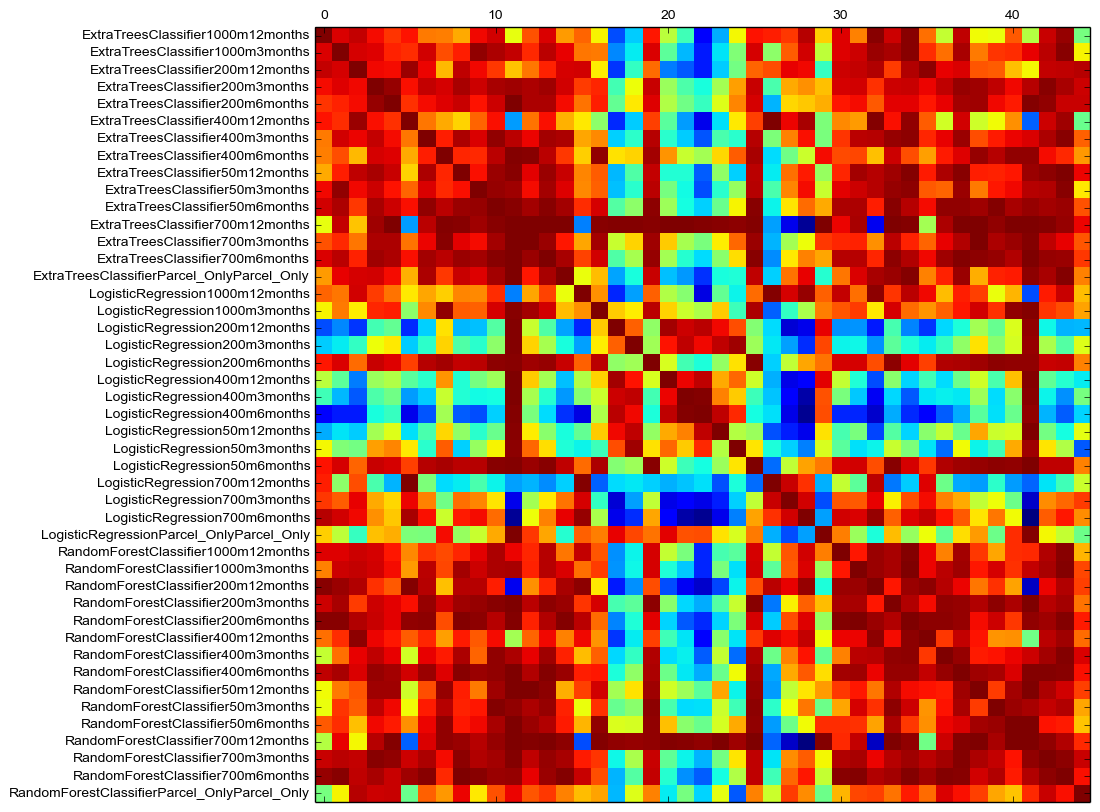

In [31]:
plot_corr(all_precisions, size = 10)

In [32]:
# Code for bokeh visualization, still working on it

# output_file("cat_heatmap.html")

# palette = palette[::-1]  # Reverse the color order so dark red is highest unemployment
# hm = HeatMap(df3, title="categorical heatmap", width=800, palette=palette)

# show(hm)

### Obtain feature importance

In [19]:
# Group by unique key

grouped_feature = data.groupby("||config||features").agg({
                               "prec_at_1":['max'],
                               "prec_at_5":['max'],"prec_at_10":['max'],
                               "prec_at_20":['max']}).reset_index()


grouped_feature.columns = ["features","prec_at_20","prec_at_1",
                        "prec_at_5","prec_at_10"]

In [20]:
grouped_feature  = grouped_feature.set_index("features").transpose()

In [22]:
grouped_feature.head()

features,"[u'crime_50m_3months.%', u'tax.%', u'census_2010.rate_%', u'names_entities.%', u'parc_area.%', u'parc_year.%', u'house_type.%', u'quarter.%', u'sixweeksweather.%']","[u'fire_200m_12months.%', u'crime_200m_12months.%', u'three11_200m_12months.%', u'sales_200m_12months.%', u'permits_200m_12months.%', u'density_200m_12months.%']","[u'fire_200m_3months.%', u'crime_200m_3months.%', u'three11_200m_3months.%', u'sales_200m_3months.%', u'permits_200m_3months.%', u'density_200m_3months.%']","[u'fire_200m_6months.%', u'crime_200m_6months.%', u'three11_200m_6months.%', u'sales_200m_6months.%', u'permits_200m_6months.%', u'density_200m_6months.%']","[u'fire_400m_12months.%', u'crime_400m_12months.%', u'three11_400m_12months.%', u'sales_400m_12months.%', u'permits_400m_12months.%', u'density_400m_12months.%']","[u'fire_400m_3months.%', u'crime_400m_3months.%', u'three11_400m_3months.%', u'sales_400m_3months.%', u'permits_400m_3months.%', u'density_400m_3months.%']","[u'fire_400m_6months.%', u'crime_400m_6months.%', u'three11_400m_6months.%', u'sales_400m_6months.%', u'permits_400m_6months.%', u'density_400m_6months.%']","[u'fire_50m_12months.%', u'crime_50m_12months.%', u'three11_50m_12months.%', u'sales_50m_12months.%', u'permits_50m_12months.%', u'density_50m_12months.%']","[u'fire_50m_3months.%', u'crime_50m_3months.%', u'three11_50m_3months.%', u'sales_50m_3months.%', u'permits_50m_3months.%', u'density_50m_3months.%', u'fire_50m_6months.%', u'crime_50m_6months.%', u'three11_50m_6months.%', u'sales_50m_6months.%', u'permits_50m_6months.%', u'density_50m_6months.%', u'fire_50m_12months.%', u'crime_50m_12months.%', u'three11_50m_12months.%', u'sales_50m_12months.%', u'permits_50m_12months.%', u'density_50m_12months.%', u'fire_200m_3months.%', u'crime_200m_3months.%', u'three11_200m_3months.%', u'sales_200m_3months.%', u'permits_200m_3months.%', u'density_200m_3months.%', u'fire_200m_6months.%', u'crime_200m_6months.%', u'three11_200m_6months.%', u'sales_200m_6months.%', u'permits_200m_6months.%', u'density_200m_6months.%', u'fire_200m_12months.%', u'crime_200m_12months.%', u'three11_200m_12months.%', u'sales_200m_12months.%', u'permits_200m_12months.%', u'density_200m_12months.%', u'fire_400m_3months.%', u'crime_400m_3months.%', u'three11_400m_3months.%', u'sales_400m_3months.%', u'permits_400m_3months.%', u'density_400m_3months.%', u'fire_400m_6months.%', u'crime_400m_6months.%', u'three11_400m_6months.%', u'sales_400m_6months.%', u'permits_400m_6months.%', u'density_400m_6months.%', u'fire_400m_12months.%', u'crime_400m_12months.%', u'three11_400m_12months.%', u'sales_400m_12months.%', u'permits_400m_12months.%', u'density_400m_12months.%', u'fire_700m_3months.%', u'crime_700m_3months.%', u'three11_700m_3months.%', u'sales_700m_3months.%', u'permits_700m_3months.%', u'density_700m_3months.%', u'fire_700m_6months.%', u'crime_700m_6months.%', u'three11_700m_6months.%', u'sales_700m_6months.%', u'permits_700m_6months.%', u'density_700m_6months.%', u'fire_700m_12months.%', u'crime_700m_12months.%', u'three11_700m_12months.%', u'sales_700m_12months.%', u'permits_700m_12months.%', u'density_700m_12months.%', u'fire_1000m_3months.%', u'crime_1000m_3months.%', u'three11_1000m_3months.%', u'sales_1000m_3months.%', u'permits_1000m_3months.%', u'density_1000m_3months.%', u'fire_1000m_6months.%', u'crime_1000m_6months.%', u'three11_1000m_6months.%', u'sales_1000m_6months.%', u'permits_1000m_6months.%', u'density_1000m_6months.%', u'fire_1000m_12months.%', u'crime_1000m_12months.%', u'three11_1000m_12months.%', u'sales_1000m_12months.%', u'permits_1000m_12months.%', u'density_1000m_12months.%', u'tax.%', u'census_2010.rate_%', u'names_entities.%', u'parc_area.%', u'parc_year.%', u'house_type.%', u'quarter.%', u'sixweeksweather.%']","[u'fire_50m_3months.%', u'crime_50m_3months.%', u'three11_50m_3months.%', u'sales_50m_3months.%', u'permits_50m_3months.%', u'density_50m_3months.%', u'fire_50m_6months.%', u'crime_50m_6months.%', u'three11_50

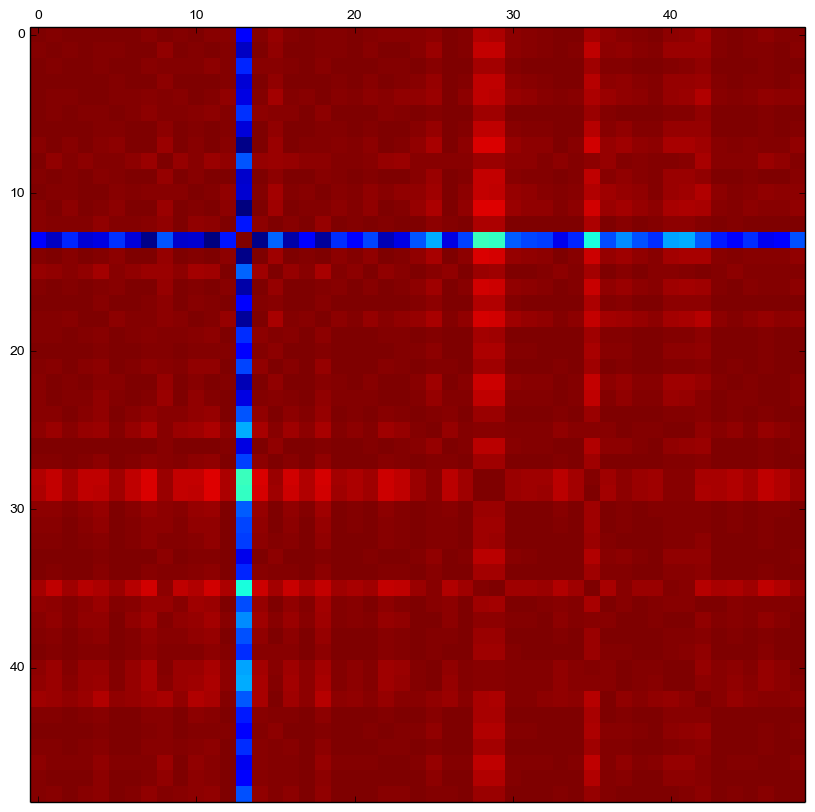

In [21]:
plot_corr(grouped_feature, size = 10)

In [34]:
sklearn_pca = sklearnPCA(n_components=2)
sklearn_pca.fit_transform(feature_data)

array([[-1.09913707,  0.61499158],
       [-1.09913707,  0.61499158],
       [-1.09913707,  0.61499158],
       ..., 
       [ 0.69503945,  0.72002766],
       [ 0.69503945,  0.72002766],
       [ 0.69503945,  0.72002766]])

In [35]:
print(sklearn_pca.explained_variance_ratio_)

[ 0.30501424  0.13624432]


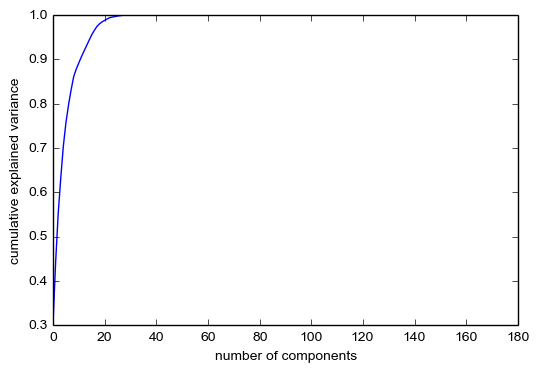

In [101]:
pca = sklearnPCA().fit(feature_data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

### Model Selection

In [43]:
data.groupby(["||config||start_date").agg({"count": "count", 
                                                   "mean": "mean", "max": "max"})

max  \
||name                 ||config||start_date ||config||validation_window             
ExtraTreesClassifier   01Jan2013            6Month                       1.000000   
                                            8Month                       0.923077   
                       30Jun2013            6Month                       1.000000   
                       30Jun2014            6Month                       1.000000   
                       31Dec2013            6Month                       1.000000   
                                            8Month                       0.948718   
                       31Dec2014            8Month                       0.923077   
LogisticRegression     01Jan2013            6Month                       0.971429   
                                            8Month                       0.897436   
                       30Jun2013            6Month                       0.942857   
                       30Jun2014            6Month                       0.971429   
                       31Dec2013            6Month                       0.900000   
                                            8Month                       0.948718   
                       31Dec2014            8Month                       0.820513   
RandomForestClassifier 01Jan2013            6Month                       1.000000   
                                            8Month                       0.976190   
                       30Jun2013            6Month                       1.000000   
                       30Jun2014            6Month                       1.000000   
                       31Dec2013            6Month                       1.000000   
                                            8Month                       1.000000   
                       31Dec2014            8Month                       0.974359   

                                                                             mean  \
||name                 ||config||start_date ||config||validation_window             
ExtraTreesClassifier   01Jan2013            6Month                       0.714332   
                                            8Month                       0.715475   
                       30Jun2013            6Month                       0.690021   
                       30Jun2014            6Month                       0.674390   
                       31Dec2013            6Month                       0.749195   
                                            8Month                       0.720172   
                       31Dec2014            8Month                       0.696753   
LogisticRegression     01Jan2013            6Month                       0.702081   
                                            8Month                       0.690607   
                       30Jun2013            6Month                       0.701956   
                       30Jun2014            6Month                       0.713109   
                       31Dec2013            6Month                       0.672341   
                                            8Month                       0.698886   
                       31Dec2014            8Month                       0.693533   
RandomForestClassifier 01Jan2013            6Month                       0.735362   
                                            8Month                       0.778530   
                       30Jun2013            6Month                       0.730373   
                       30Jun2014            6Month                       0.699448   
                       31Dec2013            6Month                       0.750268   
                                            8Month                       0.760377   
                       31Dec2014            8Month                       0.722161   

                                                                         count  
||name                 ||config||start_date ||config||validation_window         
Extr

In [98]:
data_sorted = data.sort_values("prec_at_10", ascending = False).head(5)

In [99]:
data_sorted

,||config||models,max_features,||config||parameters||random_state,||cutoff_at_1,||config||experiment_name,||cutoff_at_5,regressor,||config||parameters||max_depth,||config||parameters||bootstrap,model_id,...,u'density_1000m_12months.%',u'sales_50m_6months.total',u'three11_200m_3months.%',u'three11_200m_6months.total',u'three11_400m_12months.total',u'sales_1000m_12months.%',u'sales_400m_6months.total',radius_features,time_features,key_1
72581,"[u'sklearn.ensemble.RandomForestClassifier', u...",sqrt,NaN,0.807250,fall2016_31Dec2013_31Dec2014_6Month_upto_50m_1...,0.752300,ExtraTreesClassifier,100.0,False,585b727bba2d6c3d2e2ed65e,...,0,0,0,0,0,0,0,50m,3months,ExtraTreesClassifier50m3months
71679,"[u'sklearn.ensemble.RandomForestClassifier', u...",sqrt,NaN,0.797417,fall2016_31Dec2013_31Dec2014_6Month_upto_50m_1...,0.746758,ExtraTreesClassifier,50.0,False,585b6413ba2d6c3d2e2ed518,...,0,0,0,0,0,0,0,50m,3months,ExtraTreesClassifier50m3months
124091,"[u'sklearn.ensemble.RandomForestClassifier', u...",sqrt,NaN,0.794141,fall2016_31Dec2013_31Dec2014_6Month_upto_50m_1...,0.744666,ExtraTreesClassifier,50.0,False,585b6bdaba2d6c3d2e2ed5d0,...,0,0,0,0,0,0,0,50m,3months,ExtraTreesClassifier50m3months
26474,"[u'sklearn.ensemble.RandomForestClassifier', u...",sqrt,NaN,0.652399,fall2016_01Jan2013_31Dec2014_6Month_only_50m_3...,0.645435,ExtraTreesClassifier,5.0,False,5846fef4073a8c8e7de97729,...,0,0,0,0,0,0,0,50m,3months,ExtraTreesClassifier50m3months
26349,"[u'sklearn.ensemble.RandomForestClassifier', u...",sqrt,NaN,0.678819,fall2016_01Jan2013_31Dec2014_6Month_only_50m_3...,0.662893,ExtraTreesClassifier,10.0,False,5846fdd0073a8c8e7de976c7,...,0,0,0,0,0,0,0,50m,3months,ExtraTreesClassifier50m3months


In [100]:
# Create CSV to use as input to get data from models 
data_sorted[["model_id","validation_date","radius_features","time_features"]].to_csv("data_for_maps.csv")

In [58]:
dcf = data_sorted.groupby(["||name","||config||start_date",
              "||config||validation_window"],as_index=False).head(10)

In [ ]:
data[]

In [60]:
dcf.groupby(["||name","||config||start_date",
              "||config||validation_window"])["||prec_at_1"].agg({"count": "count", 
                                                   "mean": "mean", "max": "max"})

max  \
||name                 ||config||start_date ||config||validation_window             
ExtraTreesClassifier   01Jan2013            6Month                       1.000000   
                                            8Month                       0.923077   
                       30Jun2013            6Month                       1.000000   
                       30Jun2014            6Month                       1.000000   
                       31Dec2013            6Month                       1.000000   
                                            8Month                       0.948718   
                       31Dec2014            8Month                       0.923077   
LogisticRegression     01Jan2013            6Month                       0.971429   
                                            8Month                       0.897436   
                       30Jun2013            6Month                       0.942857   
                       30Jun2014            6Month                       0.971429   
                       31Dec2013            6Month                       0.900000   
                                            8Month                       0.948718   
                       31Dec2014            8Month                       0.820513   
RandomForestClassifier 01Jan2013            6Month                       1.000000   
                                            8Month                       0.976190   
                       30Jun2013            6Month                       1.000000   
                       30Jun2014            6Month                       1.000000   
                       31Dec2013            6Month                       1.000000   
                                            8Month                       1.000000   
                       31Dec2014            8Month                       0.974359   

                                                                             mean  \
||name                 ||config||start_date ||config||validation_window             
ExtraTreesClassifier   01Jan2013            6Month                       0.995000   
                                            8Month                       0.894026   
                       30Jun2013            6Month                       0.971737   
                       30Jun2014            6Month                       0.974286   
                       31Dec2013            6Month                       0.967500   
                                            8Month                       0.925641   
                       31Dec2014            8Month                       0.890564   
LogisticRegression     01Jan2013            6Month                       0.949286   
                                            8Month                       0.869231   
                       30Jun2013            6Month                       0.920000   
                       30Jun2014            6Month                       0.934444   
                       31Dec2013            6Month                       0.852500   
                                            8Month                       0.879487   
                       31Dec2014            8Month                       0.812821   
RandomForestClassifier 01Jan2013            6Month                       1.000000   
                                            8Month                       0.972228   
                       30Jun2013            6Month                       0.988571   
                       30Jun2014            6Month                       0.980079   
                       31Dec2013            6Month                       0.977561   
                                            8Month                       0.966667   
                       31Dec2014            8Month                       0.953846   

                                                                         count  
||name                 ||config||start_date ||config||validation_window         
Extr

## Analyze models

In [7]:
feature_freq = {}
for feature in feature_set:
    feature_freq[feature] = sum(data[feature])

In [11]:
for key, value in sorted(feature_freq.items(), key = lambda x: x[1], reverse = True):
    print("{}: {}".format(key, value))

 u'house_type.%': 109561
 u'sixweeksweather.%': 109561
 u'parc_year.%': 109561
 u'census_2010.rate_%': 109561
 u'quarter.%': 109561
u'tax.%': 109561
 u'parc_area.%': 109561
 u'named_entities.%': 102859
u'fire_50m_3months.%': 48669
u'crime_50m_3months.%': 48669
 u'sales_50m_3months.%': 48668
 u'crime_50m_3months.%': 48668
 u'three11_50m_3months.%': 48668
 u'permits_50m_3months.%': 48668
 u'density_50m_3months.%': 48667
 u'fire_50m_3months.%': 43135
 u'permits_400m_3months.%': 34146
 u'sales_400m_3months.%': 34146
u'fire_400m_3months.%': 34146
 u'crime_400m_3months.%': 34146
 u'three11_400m_3months.%': 34146
 u'density_400m_3months.%': 34145
 u'fire_400m_3months.%': 31196
 u'permits_50m_12months.%': 28292
u'fire_50m_12months.%': 28292
 u'crime_50m_12months.%': 28292
 u'three11_50m_12months.%': 28292
 u'sales_50m_12months.%': 28292
 u'density_50m_12months.%': 28291
 u'fire_50m_12months.%': 25342
 u'crime_400m_12months.%': 20874
u'fire_400m_12months.%': 20874
 u'permits_400m_12months.%': 2

In [32]:
feature_prec_1 = {}
for feature in feature_set:
    feature_prec_1[feature] = data.ix[data[feature]==1,"||prec_at_1"].mean()

In [33]:
for key, value in sorted(feature_prec_1.items(), key = lambda x: x[1], reverse = True):
    print("{}: {}".format(key, value))

 u'density_50m_3months.%': 0.7595082743881758
 u'fire_50m_3months.%': 0.7562151268762819
u'crime_50m_3months.%': 0.7548296667216723
 u'sales_50m_3months.%': 0.7548293256576322
 u'crime_50m_3months.%': 0.7548293256576322
 u'three11_50m_3months.%': 0.7548293256576322
 u'permits_50m_3months.%': 0.7548293256576322
u'fire_50m_3months.%': 0.7548279055536656
 u'fire_700m_12months.%': 0.7506734964902296
 u'permits_1000m_6months.%': 0.7506734964902296
 u'fire_700m_3months.%': 0.7506734964902296
 u'three11_1000m_6months.%': 0.7506734964902296
 u'crime_1000m_6months.%': 0.7506734964902296
 u'fire_700m_6months.%': 0.7506734964902296
 u'density_1000m_6months.%': 0.7506734964902296
 u'fire_1000m_6months.%': 0.7506734964902296
 u'sales_1000m_6months.%': 0.7506734964902296
 u'fire_400m_3months.%': 0.7454730541783513
 u'density_50m_12months.%': 0.7431464557936573
 u'density_400m_3months.%': 0.7410097810084812
 u'density_1000m_3months.%': 0.7403662479390135
 u'permits_400m_3months.%': 0.7403540313094055

In [34]:
feature_prec_5 = {}
for feature in feature_set:
    feature_prec_5[feature] = data.ix[data[feature]==1,"||prec_at_5"].mean()

In [36]:
for key, value in sorted(feature_prec_5.items(), key = lambda x: x[1], reverse = True):
    print("{}: {}".format(key, value))

 u'fire_50m_3months.%': 0.73503986270309
 u'sales_50m_3months.%': 0.7325668947234147
 u'crime_50m_3months.%': 0.7325668947234147
 u'three11_50m_3months.%': 0.7325668947234147
 u'permits_50m_3months.%': 0.7325668947234147
u'fire_50m_3months.%': 0.7325667859443676
u'crime_50m_3months.%': 0.7325664693502215
 u'density_50m_3months.%': 0.7319081422262176
 u'fire_400m_3months.%': 0.7242005900128847
 u'fire_50m_12months.%': 0.7231589062411771
 u'density_400m_3months.%': 0.7194187214697069
 u'permits_400m_3months.%': 0.7189809346561994
 u'sales_400m_3months.%': 0.7189809346561994
u'fire_400m_3months.%': 0.7189809346561994
 u'crime_400m_3months.%': 0.7189809346561994
 u'three11_400m_3months.%': 0.7189809346561994
 u'permits_50m_12months.%': 0.7189206841635669
u'fire_50m_12months.%': 0.7189206841635669
 u'crime_50m_12months.%': 0.7189206841635669
 u'three11_50m_12months.%': 0.7189206841635669
 u'sales_50m_12months.%': 0.7189206841635669
 u'density_1000m_3months.%': 0.7184925570298875
 u'density_

In [32]:
data.ix[:,"||config||validation_window"].unique()

array(['6Month', '8Month'], dtype=object)

In [41]:
data.groupby("regressor").agg({"regressor":['count'],"||prec_at_5":['mean']})

,||prec_at_5,regressor
,mean,count
regressor,,
ExtraTreesClassifier,0.697656,68228
LogisticRegression,0.697252,4342
RandomForestClassifier,0.712331,69812


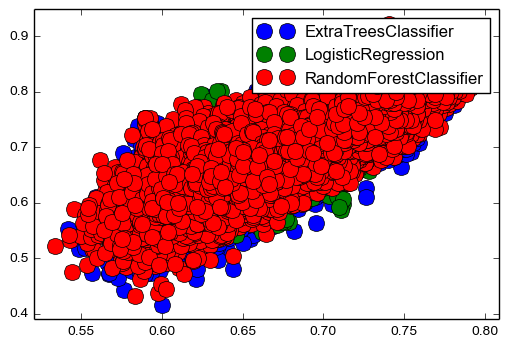

In [30]:
# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
groups = data.groupby("||name")
for name, group in groups:
    ax.plot(group["||prec_at_20"], group["||prec_at_5"], marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.show()

In [63]:
result = data.sort("||prec_at_5", ascending = False)
result[1:5]["||prec_at_5"]

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


53280     0.916667
52253     0.916667
85130     0.916667
108285    0.910714
Name: ||prec_at_5, dtype: float64

In [6]:
data.head

<bound method DataFrame.head of                                          ||config||models  \
0       [u'sklearn.ensemble.RandomForestClassifier', u...   
1       [u'sklearn.ensemble.RandomForestClassifier', u...   
2       [u'sklearn.ensemble.RandomForestClassifier', u...   
3       [u'sklearn.ensemble.RandomForestClassifier', u...   
4       [u'sklearn.ensemble.RandomForestClassifier', u...   
5       [u'sklearn.ensemble.RandomForestClassifier', u...   
6       [u'sklearn.ensemble.RandomForestClassifier', u...   
7       [u'sklearn.ensemble.RandomForestClassifier', u...   
8       [u'sklearn.ensemble.RandomForestClassifier', u...   
9       [u'sklearn.ensemble.RandomForestClassifier', u...   
10      [u'sklearn.ensemble.RandomForestClassifier', u...   
11      [u'sklearn.ensemble.RandomForestClassifier', u...   
12      [u'sklearn.ensemble.RandomForestClassifier', u...   
13      [u'sklearn.ensemble.RandomForestClassifier', u...   
14      [u'sklearn.ensemble.RandomForestClassifier', 

In [7]:
list(data.columns.values)

['||config||models',
 '||parameters||max_features',
 '||config||parameters||random_state',
 '||cutoff_at_1',
 '||config||experiment_name',
 '||cutoff_at_5',
 '||name',
 '||config||parameters||max_depth',
 '||config||parameters||bootstrap',
 '||_id',
 '||parameters||max_depth',
 '||config||parameters||warm_start',
 '||config||parameters||class_weight',
 '||parameters||n_estimators',
 '||prec_at_20',
 '||config||start_date',
 '||config||parameters||n_jobs',
 '||parameters||criterion',
 '||prec_at_1',
 '||config||residential_only',
 '||cutoff_at_20',
 '||prec_at_5',
 '||parameters||max_leaf_nodes',
 '||parameters||verbose',
 '||experiment_name',
 '||config||parameters||verbose',
 '||parameters||n_jobs',
 '||parameters||oob_score',
 '||config||validation_window',
 '||config||parameters||min_weight_fraction_leaf',
 '||parameters||min_samples_leaf',
 '||parameters||warm_start',
 '||config||features',
 '||parameters||min_samples_split',
 '||config||parameters||oob_score',
 '||parameters||boot

In [8]:
data['||config||experiment_name']

0         fall2016_30Jun2014_30Jun2015_6Month_parcel_onl...
1         fall2016_30Jun2014_30Jun2015_6Month_parcel_onl...
2         fall2016_30Jun2014_30Jun2015_6Month_parcel_onl...
3         fall2016_30Jun2014_30Jun2015_6Month_parcel_onl...
4         fall2016_30Jun2014_30Jun2015_6Month_parcel_onl...
5         fall2016_30Jun2014_30Jun2015_6Month_parcel_onl...
6         fall2016_30Jun2014_30Jun2015_6Month_parcel_onl...
7         fall2016_30Jun2014_30Jun2015_6Month_parcel_onl...
8         fall2016_30Jun2014_30Jun2015_6Month_parcel_onl...
9         fall2016_30Jun2014_30Jun2015_6Month_parcel_onl...
10        fall2016_30Jun2014_30Jun2015_6Month_parcel_onl...
11        fall2016_30Jun2014_30Jun2015_6Month_parcel_onl...
12        fall2016_30Jun2014_30Jun2015_6Month_parcel_onl...
13        fall2016_30Jun2014_30Jun2015_6Month_parcel_onl...
14        fall2016_30Jun2014_30Jun2015_6Month_parcel_onl...
15        fall2016_30Jun2014_30Jun2015_6Month_parcel_onl...
16        fall2016_30Jun2014_30Jun2015_6

In [ ]:
data[["model_id","start_date",'||config||features']]